## <span style="color:#ff5f27;"> 📝 Imports</span>

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from hops import hdfs

project_path = hdfs.project_path()

project_path

'hdfs://rpc.namenode.service.consul:8020/Projects/electricity/'

## <span style="color:#ff5f27;"> 🔮 Connecting to Hopsworks Feature Store </span>

In [3]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;">🧑🏻‍🏫 Functions</span>

In [4]:
def get_data(data_path):
    df = pd.read_csv(data_path,
        index_col = 0,
        parse_dates = ['date']
    ).dropna()
    return df    


def timestamp_2_time(x):
    dt_obj = datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
    dt_obj = dt_obj.timestamp() * 1000
    return dt_obj


def to_date(unix):
    return datetime.utcfromtimestamp(unix / 1000).strftime('%Y-%m-%d %H:%M:%S')


def feature_engineering(df):
    df[['holiday','school_day']] = df[['holiday','school_day']].apply(lambda x: x.map({'Y': 1, 'N': 0}))
    if type(df.date[0]) != np.int64:
        df.date = df.date.apply(lambda x: timestamp_2_time(str(x)[:19])).astype(np.int64)
    return df


def create_feature_group(data = None,name='calendar_fg',fs=fs):
    import great_expectations as ge
    
    expectation_suite = ge.core.ExpectationSuite(
        expectation_suite_name="Expectation Suite for Calendar Feature Group"
    )

    expectation = ge.core.ExpectationConfiguration(
       expectation_type="expect_column_value_lengths_to_be_between",
       kwargs={
          "column": "school_day",
          "min_value": 1,
           "max_value": 1,
       },
        meta={
          "notes": {
             "format": "markdown",
             "content": "Possible values for `holiday` column are **Y** and **No**. *Meaning*: is a specific day a holiday or not."
          }
       }
    )

    expectation_suite.add_expectation(expectation)
    
    feature_group = fs.get_or_create_feature_group(
        name=name,
        description = 'Characteristics of each day',
        version = 1,
        primary_key = ['index'],
        online_enabled = True,
        event_time = ['date'],
        expectation_suite=expectation_suite
    )
        
    feature_group.insert(data.reset_index())
    
    return feature_group


def retrieve_feature_group(name='calendar_fg',fs=fs):
    feature_group = fs.get_feature_group(
        name=name,
        version=1
    )
    return feature_group

## <span style="color:#ff5f27;">🪄 👩🏻‍🔬 Retrieving or Creating Feature Group</span>

In [5]:
try:
    feature_group = retrieve_feature_group()
    df_calendar = feature_group.read()
    indexes = df_calendar.pop('index')
    
except: 
    DATA_PATH = project_path + 'Jupyter/data/calendar.csv'
    
    df_calendar = get_data(DATA_PATH)
    feature_engineering(df_calendar)
    
    feature_group = create_feature_group(df_calendar)

2022-08-22 08:09:14,653 INFO: USE `electricity_featurestore`
2022-08-22 08:09:15,340 INFO: SELECT `fg0`.`index` `index`, `fg0`.`date` `date`, `fg0`.`school_day` `school_day`, `fg0`.`holiday` `holiday`
FROM `electricity_featurestore`.`calendar_fg_1` `fg0`


In [6]:
df_calendar.head()

,date,school_day,holiday
0,1583020800000,1,0
1,1596240000000,1,0
2,1536451200000,1,0
3,1474848000000,0,0
4,1420761600000,0,0


## <span style="color:#ff5f27;">🕵🏻‍♂️ Data Exploration</span>

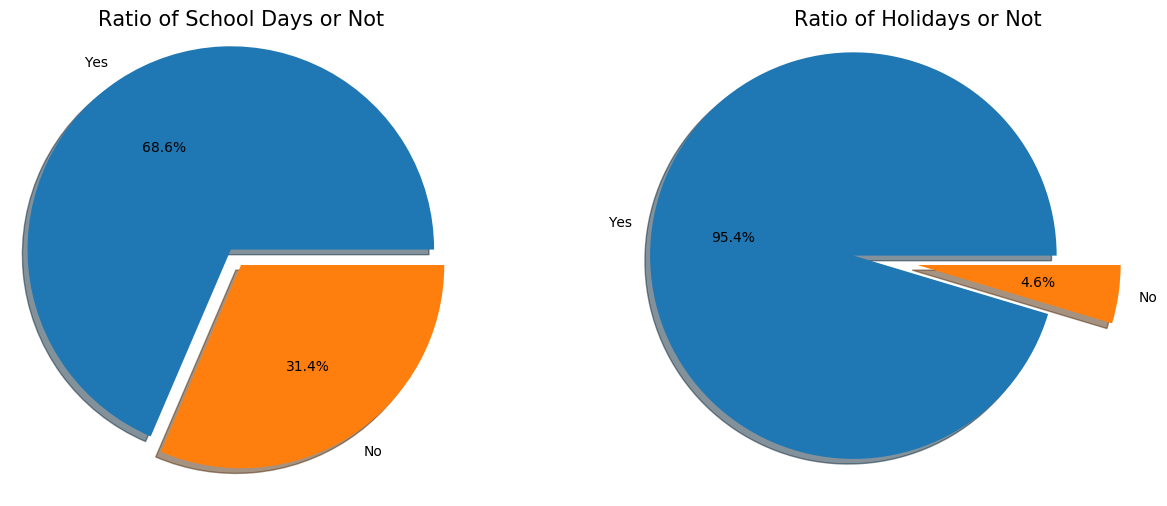

In [7]:
fig,ax = plt.subplots(1,2,figsize = (16,6))

ax[0].pie(
    df_calendar.school_day.value_counts(),
    labels = ['Yes','No'],
    explode = [0.1, 0],
    shadow=True,
    autopct='%1.1f%%',
    radius = 1.1
)

ax[1].pie(
    df_calendar.holiday.value_counts(),
    labels = ['Yes','No'],
    explode = [0.35, 0],
    shadow=True,
    autopct='%1.1f%%',
    radius = 1.1
)

ax[0].set_title("Ratio of School Days or Not", fontsize = 15)
ax[1].set_title("Ratio of Holidays or Not", fontsize = 15)

plt.show()

## <span style="color:#ff5f27;">🧬 Data Generation</span>

In [8]:
date_window = 24*60*60*1000

In [9]:
def generate_observation(columns):
    return [random.choice(['Y','N'],) for col in columns[1:]]

def generate_data(df,amount = 1,date_window = date_window):
    df_last = df.sort_values('date').date.iloc[-1]
    df_generated = pd.DataFrame(columns = ['date',*df.columns[1:]])
    for i in range(1, amount + 1):
        df_generated.loc[len(df_generated)] = [df_last + date_window * i,*generate_observation(df.columns)]
    return df_generated.astype({'date':int})

def append_generated_data(df,amount = 1,date_window = date_window):
    df_last = df.sort_values('date').date.iloc[-1]
    for i in range(1, amount + 1):
        df.loc[len(df)] = [df_last + date_window,*generate_observation(df.columns)]
    return df

## <span style="color:#ff5f27;">👩🏻‍⚖️ 🪄 Validation and Insertion of Generated Data</span>

In [10]:
def add_indexes(df,indexes=None):
    if indexes is None:
        return df.reset_index()
    df.reset_index(inplace = True)
    df['index'] = df['index'] + indexes.max() + 1
    return df

In [11]:
generated_data = generate_data(df_calendar,50)
feature_engineering(generated_data)

try: 
    generated_data = add_indexes(generated_data,indexes)
except:
    generated_data = add_indexes(generated_data)

generated_data.head()

,index,date,school_day,holiday
0,0,1606348800000,1,1
1,1,1606435200000,0,0
2,2,1606521600000,1,1
3,3,1606608000000,0,1
4,4,1606694400000,1,0


In [12]:
feature_group.insert(generated_data)

2022-08-22 08:09:17,437 INFO: 	1 expectation(s) included in expectation_suite.
Validation Report saved successfully, explore a summary at https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/fs/68/fg/4109


Uploading Dataframe: 0.00% |          | Rows 0/50 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://ed408010-19ac-11ed-9333-c9e9623aac8a.cloud.hopsworks.ai/p/120/jobs/named/calendar_fg_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7fa1e3703f10>,
 {
   "evaluation_parameters": {},
   "meta": {
     "great_expectations_version": "0.14.3",
     "expectation_suite_name": "Expectation Suite for Calendar Feature Group",
     "run_id": {
       "run_time": "2022-08-22T08:09:17.437459+00:00",
       "run_name": null
     },
     "batch_kwargs": {
       "ge_batch_id": "b7e3f58a-21f1-11ed-953f-3e12410945e9"
     },
     "batch_markers": {},
     "batch_parameters": {},
     "validation_time": "20220822T080917.437331Z",
     "expectation_suite_meta": {
       "great_expectations_version": "0.14.3"
     }
   },
   "results": [
     {
       "result": {
         "element_count": 50,
         "missing_count": 0,
         "missing_percent": 0.0,
         "unexpected_count": 0,
         "unexpected_percent": 0.0,
         "unexpected_percent_total": 0.0,
         "unexpected_percent_nonmissing": 0.0,
         "partial_unexpected_list": []
       },
       "exception_info": {
         "raised_exception"